Import the libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from textblob import TextBlob
from nltk.stem import PorterStemmer

from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from io import StringIO
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Importing the data

In [30]:
data = pd.read_csv("vaccination_tweets.csv")
data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


Selecting required columns and rows

In [31]:
data=pd.concat([data.text, data.user_verified],axis=1)
data.dropna(axis=0,inplace=True)  # For drop nan values. It makes confuse for our model.
data.tail()

,text,user_verified
2260,I'm still unsure as to whether or not I will h...,False
2261,Order of priority for vaccine against C19.\n\n...,False
2262,So the vaccination has started in Berlin and B...,False
2263,The money shot... #pfizerbiontech #latechristm...,False
2264,#PfizerBioNTech Why haven't you submitted the ...,False


Data Understanding

In [32]:
data.dtypes

text             object
user_verified      bool
dtype: object

In [33]:
data = data[pd.notnull(data['text'])]

In [34]:
data.head()

,text,user_verified
0,Same folks said daikon paste could treat a cyt...,False
1,While the world has been on the wrong side of ...,False
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,False
3,"Facts are immutable, Senator, even when you're...",True
4,Explain to me again why we need a vaccine @Bor...,False


Factorizing the category column

In [35]:
data['category_id'] = data['user_verified'].factorize()[0]

data.head()

,text,user_verified,category_id
0,Same folks said daikon paste could treat a cyt...,False,0
1,While the world has been on the wrong side of ...,False,0
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,False,0
3,"Facts are immutable, Senator, even when you're...",True,1
4,Explain to me again why we need a vaccine @Bor...,False,0


Check the ditribution of complaints by category

In [36]:
data.groupby('user_verified').text.count()

user_verified
False    1934
True      331
Name: text, dtype: int64

Plot it

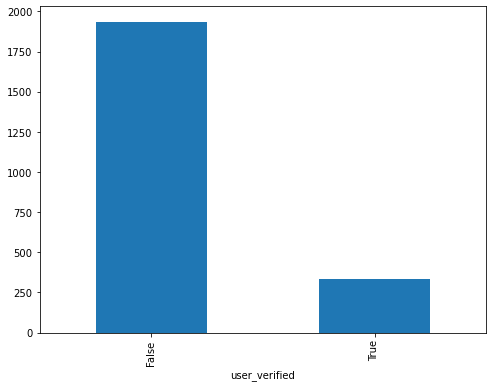

In [37]:
fig = plt.figure(figsize = (8, 6))
data.groupby('user_verified').text.count().plot.bar(ylim = 0)


Splitting the data into train and validation

In [38]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(data['text'], data['user_verified'])

Feature engineering using TF-IDF

Consider maximum features to be 5000

In [39]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

tfidf_vect = TfidfVectorizer(analyzer = 'word', token_pattern = r'\w{1,}', max_features=5000)
tfidf_vect.fit(data['text'])

xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)


Model building and evaluation

In [40]:
model = linear_model.LogisticRegression().fit(xtrain_tfidf, train_y)

Model summary

In [41]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                   penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

Checking accuracy

In [42]:
accuracy = metrics.accuracy_score(model.predict(xvalid_tfidf), valid_y)
print ("Accuracy: ", accuracy)

Accuracy:  0.8606701940035273


confusiom matrix

In [43]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, model.predict(xvalid_tfidf))

Vizualizing confusion matrix

/home/chi/anaconda3/envs/nltkENv/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


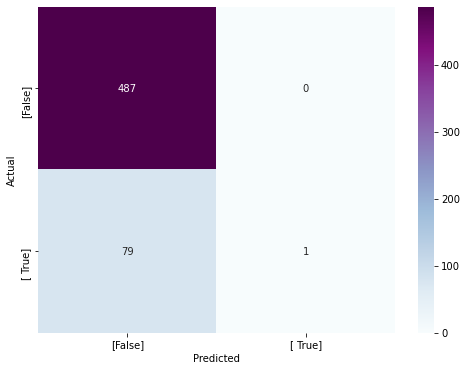

In [44]:
category_id_df = data[['user_verified', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'user_verified']].values)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="BuPu", xticklabels=category_id_df[['user_verified']].values,
yticklabels=category_id_df[['user_verified']].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()